In [17]:
import numpy as np
from datasets import load_dataset

from transformers import AutoModelForCausalLM, AutoTokenizer

model_id = 'EleutherAI/gpt-neo-2.7B'
model = AutoModelForCausalLM.from_pretrained(model_id, device_map='auto', torch_dtype='float16')
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

xlsum = load_dataset('anakib1/mango-truth', 'xlsum')['train']

Some parameters are on the meta device because they were offloaded to the disk.


In [19]:
labler = xlsum.features['label']
human = xlsum.filter(lambda x: x['label'] == labler.str2int('human')).select(range(1000))
ai = xlsum.filter(lambda x: x['label'] == labler.str2int('gpt-4o-mini'))

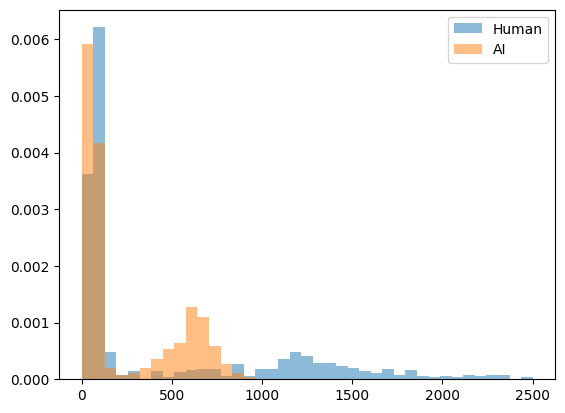

In [20]:
from matplotlib import pyplot as plt

bins = np.linspace(0, 2500, 40)
plt.hist(human.map(lambda x: {"length": len(x['output'].split())})['length'], bins=bins, density=True, label='Human',
         alpha=0.5)
plt.hist(ai.map(lambda x: {"length": len(x['output'].split())})['length'], bins=bins, density=True, label='AI',
         alpha=0.5)
plt.legend()

In [25]:
from tqdm.auto import tqdm
import torch

BATCH_SIZE = 4


def calculate_perplexity(dataset, text_column):
    results = []
    for i in tqdm(range(0, len(dataset), BATCH_SIZE)):
        inputs = tokenizer(dataset[text_column][i:i + BATCH_SIZE], padding='max_length', truncation=True,
                           return_tensors='pt',
                           max_length=tokenizer.model_max_length)
        with torch.no_grad():
            logits = model(**inputs.to(model.device))
        raw_perplexity = torch.nn.functional.cross_entropy(logits['logits'].permute(0, 2, 1), inputs['input_ids'],
                                                           reduction='none')

        raw_perplexity[inputs['input_ids'] == tokenizer.pad_token_id] = 0
        perplexities = raw_perplexity.sum(dim=1) / inputs['attention_mask'].sum(dim=1)
        results.append(perplexities.exp().cpu())

    return torch.concatenate(results, dim=0)

In [26]:
human_perplexities = np.array(calculate_perplexity(human, 'output').cpu())
llm_perplexities = np.array(calculate_perplexity(ai, 'output').cpu())

  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
human_perplexities

array([10855.54  , 21449.514 ,  9402.79  , 30414.209 , 12077.556 ,
       20352.082 , 11680.755 , 26433.523 , 16207.629 , 21728.49  ,
       19130.428 , 13819.032 , 14058.045 , 15004.079 , 23571.777 ,
       20492.232 , 18989.777 , 18012.332 , 16018.591 , 23517.012 ,
       27374.42  , 13750.462 , 20384.717 , 17866.482 , 14293.828 ,
        8894.363 , 17235.58  , 19636.572 , 15833.568 , 19827.043 ,
       30258.07  , 10811.651 , 16454.166 , 15220.46  , 17735.936 ,
       17277.992 , 13462.198 , 13279.093 , 22223.645 , 18175.344 ,
       21542.627 , 12798.737 , 22113.203 , 20354.45  , 24122.734 ,
       18901.207 , 17685.838 , 18685.438 , 10508.113 ,  9782.4   ,
       26010.31  , 22249.367 , 15909.87  , 14542.3   , 39688.23  ,
       19348.771 , 11187.524 , 24198.447 , 16346.154 , 22221.525 ,
       14798.762 , 29708.531 , 13419.41  , 18852.242 , 20703.674 ,
       12974.699 , 21339.215 , 19803.27  , 21814.574 , 12356.1045,
       38530.742 , 15142.308 , 18923.174 , 14366.478 , 15435.0

MLCommons Mean Perplexity: 18827.0390625
XLSum Mean Perplexity: 19316.177734375


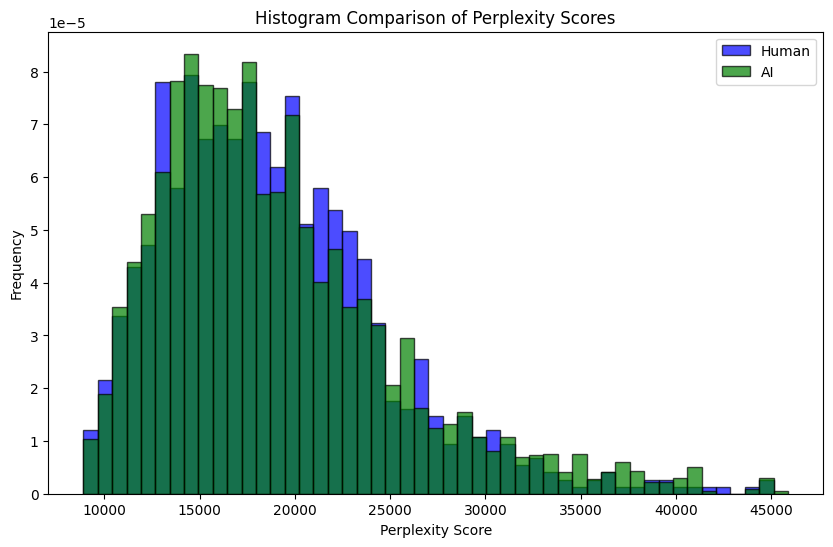

In [39]:
import matplotlib.pyplot as plt

bins = np.linspace(np.percentile(np.concat([human_perplexities, llm_perplexities]), 1),
                   np.percentile(np.concat([human_perplexities, llm_perplexities]), 99), 50)

print(f"MLCommons Mean Perplexity: {human_perplexities.mean()}")
print(f"XLSum Mean Perplexity: {llm_perplexities.mean()}")

plt.figure(figsize=(10, 6))

plt.hist(human_perplexities, bins=bins, alpha=0.7, label='Human', color='blue', edgecolor='black', density=True)
plt.hist(llm_perplexities, bins=bins, alpha=0.7, label='AI', color='green', edgecolor='black', density=True)

plt.xlabel('Perplexity Score')
plt.ylabel('Frequency')
plt.title('Histogram Comparison of Perplexity Scores')
plt.legend()
plt.show()